# Regressão Linear 

Modelo de regressão linear usado como *baseline*

Esse notebook treina diferentes modelos de regressão linear para prever a demanda por cimento.

Índices:
1.   Modelo único para prever para todos os estados (`MUCE`)
2.   Modelo único sem indicar o estado (`MUSE`)
3.   Um modelo para cada estado (`MSPE`)

Em cada um dos modelos acima, fizemos testes aplicando 3 métodos de normalização de dados: standardscaler (`SS`), minmaxscaler (`MM`) e powertransformer (`PT`)
 e também ser normalizar (`SN`). 
 
 Ao final, comparamos os resultados dos diferentes modelos.
 
 Para comparação da acurácia utilizamos os indicadores:
 
 MAE (Mean Absolute Error):
 
 $$ MAE(y_r, y_p) = \frac{\sum_{i=0}^n | y_{r_i} - y_{p_i} |}{n}$$
 
 MAPE (Mean Absolute Percentual Error)
 
 $$MAPE(y_r, y_p) = \frac{1}{n}\sum_{i=0}^n \frac{| y_{r_i} - y_{p_i} |}{max(\epsilon, |y_{r_i}|)}$$
 
RMSE (Root Mean Squared Error)
 
 $$ RMSE(y_r, y_p) = \sqrt{\frac{\sum_{i=0}^n ( y_{r_i} - y_{p_i} )^2}{n}} $$

In [1]:
# importamos as libs
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
import numpy as np

sns.set_palette("Set2")

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

## Fast Fourier Transform
from numpy.fft import rfft, irfft, rfftfreq, irfftn

## Funções e constantes

In [2]:
### Constantes que definimos

ANO_INICIAL = 1991
ANO_FINAL = 2019
ANO_BASE = 2017

PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/"

SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

MAP = dict(zip(SIGLAS, [i for i in range(27)]))

labels=["subestima: -90%", "subestima entre -90% e 60%", "subestima entre -60% e -30%",
        "subestima entre -30% e 10%", "entre -10% e 10%", "superestima entre 10% e 30%",
        "superestima entre 30% e 60%", "superestima entre 60% e 90%", "superestima mais de 90%"]

In [3]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "neg_root_mean_squared_error": RMSE,
        "neg_mean_absolute_error": MAE,
        "neg_mean_absolute_percentage_error": MAPE,
    }

    return scores

def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['neg_root_mean_squared_error']}")
    print (f"MAE: {scores['neg_mean_absolute_error']}")
    print (f"MAPE: {scores['neg_mean_absolute_percentage_error']}")


In [4]:
def compare_pred (m1,l1, m2, l2):
    plt.figure(figsize=(24,45))

    for state in range(27):

        plt.subplot(9,3,state+1)
        
        plt.yscale('linear')

        plt.title (f"Distribuição do erro do estado {SIGLAS[state]}")

        # pred = y_pred[state]
        # real = y_test[state]

        plt.plot(pd.DataFrame(m2[SIGLAS[state]]["y_pred"]), label=f"Previsão com {l2}", color="purple")
        plt.plot(pd.DataFrame(m1[SIGLAS[state]]["y_pred"]), label=f"Previsão com {l1}", color="coral")
        plt.plot(pd.DataFrame(m1[SIGLAS[state]]["y_test"]), label="Dado Real", color="deepskyblue")

        plt.legend()
    plt.show()

In [5]:
def show_predictions_graphs (data):

    plt.figure(figsize=(24,45))

    for state in range(27):

        plt.subplot(9,3,state+1)
        
        plt.yscale('linear')

        plt.title (f"Distribuição do erro do estado {SIGLAS[state]}")

        # pred = y_pred[state]
        # real = y_test[state]

        plt.plot(pd.DataFrame(data[SIGLAS[state]]["y_pred"]), label="Previsão", color="coral")
        plt.plot(pd.DataFrame(data[SIGLAS[state]]["y_test"]), label="Dado Real", color="darkgreen")

        plt.legend()
    plt.show()

In [6]:
def split_y_state (y):

    if type(y) == np.ndarray:

        return dict(zip([i for i in range(27)], [[y[i] for i in range(s, len(y), 27)] for s in range(27)]))

    return dict(zip([i for i in range(27)], [[y.iloc[i] for i in range(s, y.size, 27)] for s in range(27)]))


In [7]:
def show_error_state(y_pred_state, y_test_state):

    plt.figure(figsize=(15,6))

    df = pd.DataFrame(SIGLAS, columns=["estados"])
    df["erro"] = [100*mean_absolute_percentage_error(y_test_state[i], y_pred_state[i]) for i in range(27)]

    sns.barplot(data=df, x="estados", y="erro", palette="Set2")
    plt.ylabel("MAPE por estado em %")

    plt.show()

In [8]:
def show_error_graphs (y_pred, y_test):

    plt.figure(figsize=(24,45))

    for state in range(27):

        plt.subplot(9,3,state+1)

        plt.title (f"Distribuição de erro do estado {SIGLAS[state]}")

        pred = y_pred[state]
        real = y_test[state]

        error = [100*(round(mean_absolute_percentage_error([real[i]],[pred[i]]), 1)) for i in range(len(pred))]

        error = [i if i <= 100 else 100.0 for i in error]

        sns.countplot(error)
        plt.xlabel("Faixa de erro")
        plt.ylabel("Número de ocorrências")

    plt.show()

In [9]:
def print_error (y_pred_state, y_test_state):

    rmse = [mean_squared_error(y_test_state[i], y_pred_state[i], squared=False) for i in range(27)]
    mape = [mean_absolute_percentage_error(y_test_state[i], y_pred_state[i]) for i in range(27)]

    #return pd.Series(rmse + [min(i, 1.0) for i in mape])
    return pd.Series(rmse + mape)

In [10]:
def categorize(x):
    if x < - 0.9:
        return labels[0]
    elif x < - 0.6:
        return labels[1]
    elif x < - 0.3:
        return labels[2]
    elif x < - 0.1:
        return labels[3]
    elif x < 0.1:
        return labels[4]
    elif x < 0.3:
        return labels[5]
    elif x < 0.6:
        return labels[6]
    elif x < 0.9:
        return labels[7]
    else:
        return labels[8]

In [11]:
def show_delta (pred):
    aux = []
    for i in range(27):
        val = list(pred.values())[i]
        val['y_pred'] = np.array(val['y_pred'])
        val['y_test'] = np.array(val['y_test'])
        aux += list((val['y_pred']-val['y_test'])/val['y_test'])

    error = pd.DataFrame(aux, columns=['erro'])
    error['categoria']=error['erro'].apply(categorize)
    
    plt.figure(figsize=(28,6))

    sns.countplot(data=error, x='categoria', order=labels)

    plt.show()

## Ler os dados

Aqui apenas lemos os dados do csv em `/data/csv/`


In [12]:
# input
x = pd.read_csv("https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/input.csv")

# target
y = pd.read_csv("https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/target_ac.csv")

In [13]:
x.head()

,estados,data,pib_pc,pib_pmc,pib_pcpt,populacao,pib_cc,ipca,incc,igp,selic,idh_long,idh_renda,idh_educacao,nfsp,estoque,desemprego
0,AC,199101,3.281564e+06,14.663360,0.708721,417102.0,1.869529e+05,6.62,4.7,19.93,2.375185,0.645,0.647,0.176,11.17,4.782147e+06,9.216314
1,AL,199101,1.419695e+07,74.802077,0.510378,2512658.0,1.045711e+06,6.62,4.7,19.93,2.375185,0.552,0.574,0.174,11.17,4.782147e+06,8.980849
2,AM,199101,1.481369e+07,192.541724,0.634686,2102766.0,1.727997e+06,6.62,4.7,19.93,2.375185,0.668,0.527,0.254,11.17,4.782147e+06,11.555730
3,AP,199101,2.553397e+06,17.042118,0.793464,289035.0,7.302087e+04,6.62,4.7,19.93,2.375185,0.645,0.620,0.204,11.17,4.782147e+06,5.922940
4,BA,199101,6.417557e+07,475.734256,0.488841,11867336.0,6.191147e+06,6.62,4.7,19.93,2.375185,0.582,0.605,0.182,11.17,4.782147e+06,8.211435


In [14]:
y.head()

,data,estados,consumo
0,199101,AC,16951.0
1,199102,AL,308951.0
2,199103,AM,259396.0
3,199104,AP,25699.0
4,199105,BA,1166517.0


# Modelo único para todos os estados

Para esse experimentos, vamos testar um modelo único para todos os estados do Brasil, adicionando aos dados um identificador para o estado.

Vamos utilizar One Hot Encoding para indicar o estado, esse método transforma uma variável categórica em colunas binárias para manter a informação necessária mas com um melhor desempenho que o Label Encoding

In [15]:
df_error = pd.DataFrame(SIGLAS*2, columns=["estados"])
df_error["indicador"] = ["RMSE"]*27 + ["MAPE"]*27

df_geral = pd.DataFrame(["RMSE", "MAPE", "MAE"], columns=["indicador"])

## Sem normalizar os dados

In [16]:
# input
x = pd.read_csv("https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/input.csv")

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv("https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/target_ac.csv")['consumo']

In [17]:
# aqui podemos observar as colunas geradas pelo método do one hot encoding
x.head()

,estados,data,pib_pc,pib_pmc,pib_pcpt,populacao,pib_cc,ipca,incc,igp,selic,idh_long,idh_renda,idh_educacao,nfsp,estoque,desemprego
0,AC,199101,3.281564e+06,14.663360,0.708721,417102.0,1.869529e+05,6.62,4.7,19.93,2.375185,0.645,0.647,0.176,11.17,4.782147e+06,9.216314
1,AL,199101,1.419695e+07,74.802077,0.510378,2512658.0,1.045711e+06,6.62,4.7,19.93,2.375185,0.552,0.574,0.174,11.17,4.782147e+06,8.980849
2,AM,199101,1.481369e+07,192.541724,0.634686,2102766.0,1.727997e+06,6.62,4.7,19.93,2.375185,0.668,0.527,0.254,11.17,4.782147e+06,11.555730
3,AP,199101,2.553397e+06,17.042118,0.793464,289035.0,7.302087e+04,6.62,4.7,19.93,2.375185,0.645,0.620,0.204,11.17,4.782147e+06,5.922940
4,BA,199101,6.417557e+07,475.734256,0.488841,11867336.0,6.191147e+06,6.62,4.7,19.93,2.375185,0.582,0.605,0.182,11.17,4.782147e+06,8.211435


In [18]:
# input
x = pd.read_csv("https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/input.csv")
x.drop("data", inplace=True, axis=1)

# processo de one-hot
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv("https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/target_ac.csv")['consumo']

# shuffle = False para os dados continuarem em ordem 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

# fazendo previsão 
y_pred = regr.predict(x_test)

Score: 0.8633707869138146


In [19]:
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

df_geral["sem normalizar"] = [scores["neg_root_mean_squared_error"], scores["neg_mean_absolute_percentage_error"], scores["neg_mean_absolute_error"]]

Scores obtidos:
RMSE: 821444.8732105653
MAE: 562083.2722216529
MAPE: 0.8010375612566666


In [20]:
# pra garantir que iniciamos a comparação a partir do ACRE
y_pred = y_pred[len(y_pred)%27:]
y_test = y_test[len(y_test)%27:]

y_test_state = split_y_state(y_test)
y_pred_state = split_y_state(y_pred)
df_error["sem normalizar"] = print_error(y_pred_state, y_test_state)

## Normalizando os dados 

### Normalização com Standard Scaler

In [21]:
# input
x = pd.read_csv("https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/input.csv")
x.drop("data", inplace=True, axis=1)

# processo de one-hot
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv("https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/target_ac.csv")['consumo']

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

# calcula media e desvio padrao do treino e normaliza os dados
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

Score: 0.8633707902792143


In [23]:
# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

df_geral["standard scaler"] = [scores["neg_root_mean_squared_error"], scores["neg_mean_absolute_percentage_error"], scores["neg_mean_absolute_error"]]

Scores obtidos:
RMSE: 821444.8630938039
MAE: 562083.2912963481
MAPE: 0.8010375936536177


In [24]:
# pra garantir que iniciamos a comparação a partir do ACRE
y_pred = y_pred[len(y_pred)%27:]
y_test = y_test[len(y_test)%27:]

y_test_state = split_y_state(y_test)
y_pred_state = split_y_state(y_pred)
df_error["standard scaler"] = print_error(y_pred_state, y_test_state)

### MinMax

In [25]:
# input
x = pd.read_csv("https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/input.csv")
x.drop("data", inplace=True, axis=1)

# processo de one-hot
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv("https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/target_ac.csv")['consumo']

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

# calcula media e desvio padrao do treino e normaliza os dados
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

Score: 0.863370790279212


In [27]:
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

df_geral["minmax scaler"] = [scores["neg_root_mean_squared_error"], scores["neg_mean_absolute_percentage_error"], scores["neg_mean_absolute_error"]]

Scores obtidos:
RMSE: 821444.8630938106
MAE: 562083.2912963507
MAPE: 0.8010375936536192


In [28]:
# pra garantir que iniciamos a comparação a partir do ACRE
y_pred = y_pred[len(y_pred)%27:]
y_test = y_test[len(y_test)%27:]

y_test_state = split_y_state(y_test)
y_pred_state = split_y_state(y_pred)
df_error["minmax scaler"] = print_error(y_pred_state, y_test_state)

### Power Transform

In [29]:
# input
x = pd.read_csv("https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/input.csv")
x.drop("data", inplace=True, axis=1)

# processo de one-hot
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv("https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/target_ac.csv")['consumo']

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

# calcula media e desvio padrao do treino e normaliza os dados
scaler = PowerTransformer()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

Score: 0.827707029401649


In [31]:
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

df_geral["powertransformer scaler"] = [scores["neg_root_mean_squared_error"], scores["neg_mean_absolute_percentage_error"], scores["neg_mean_absolute_error"]]

Scores obtidos:
RMSE: 922444.868853487
MAE: 703952.4578285577
MAPE: 0.85113264664176


In [32]:
# pra garantir que iniciamos a comparação a partir do ACRE
y_pred = y_pred[len(y_pred)%27:]
y_test = y_test[len(y_test)%27:]

y_test_state = split_y_state(y_test)
y_pred_state = split_y_state(y_pred)
df_error["powertransform scaler"] = print_error(y_pred_state, y_test_state)

## Comparação de desempenho

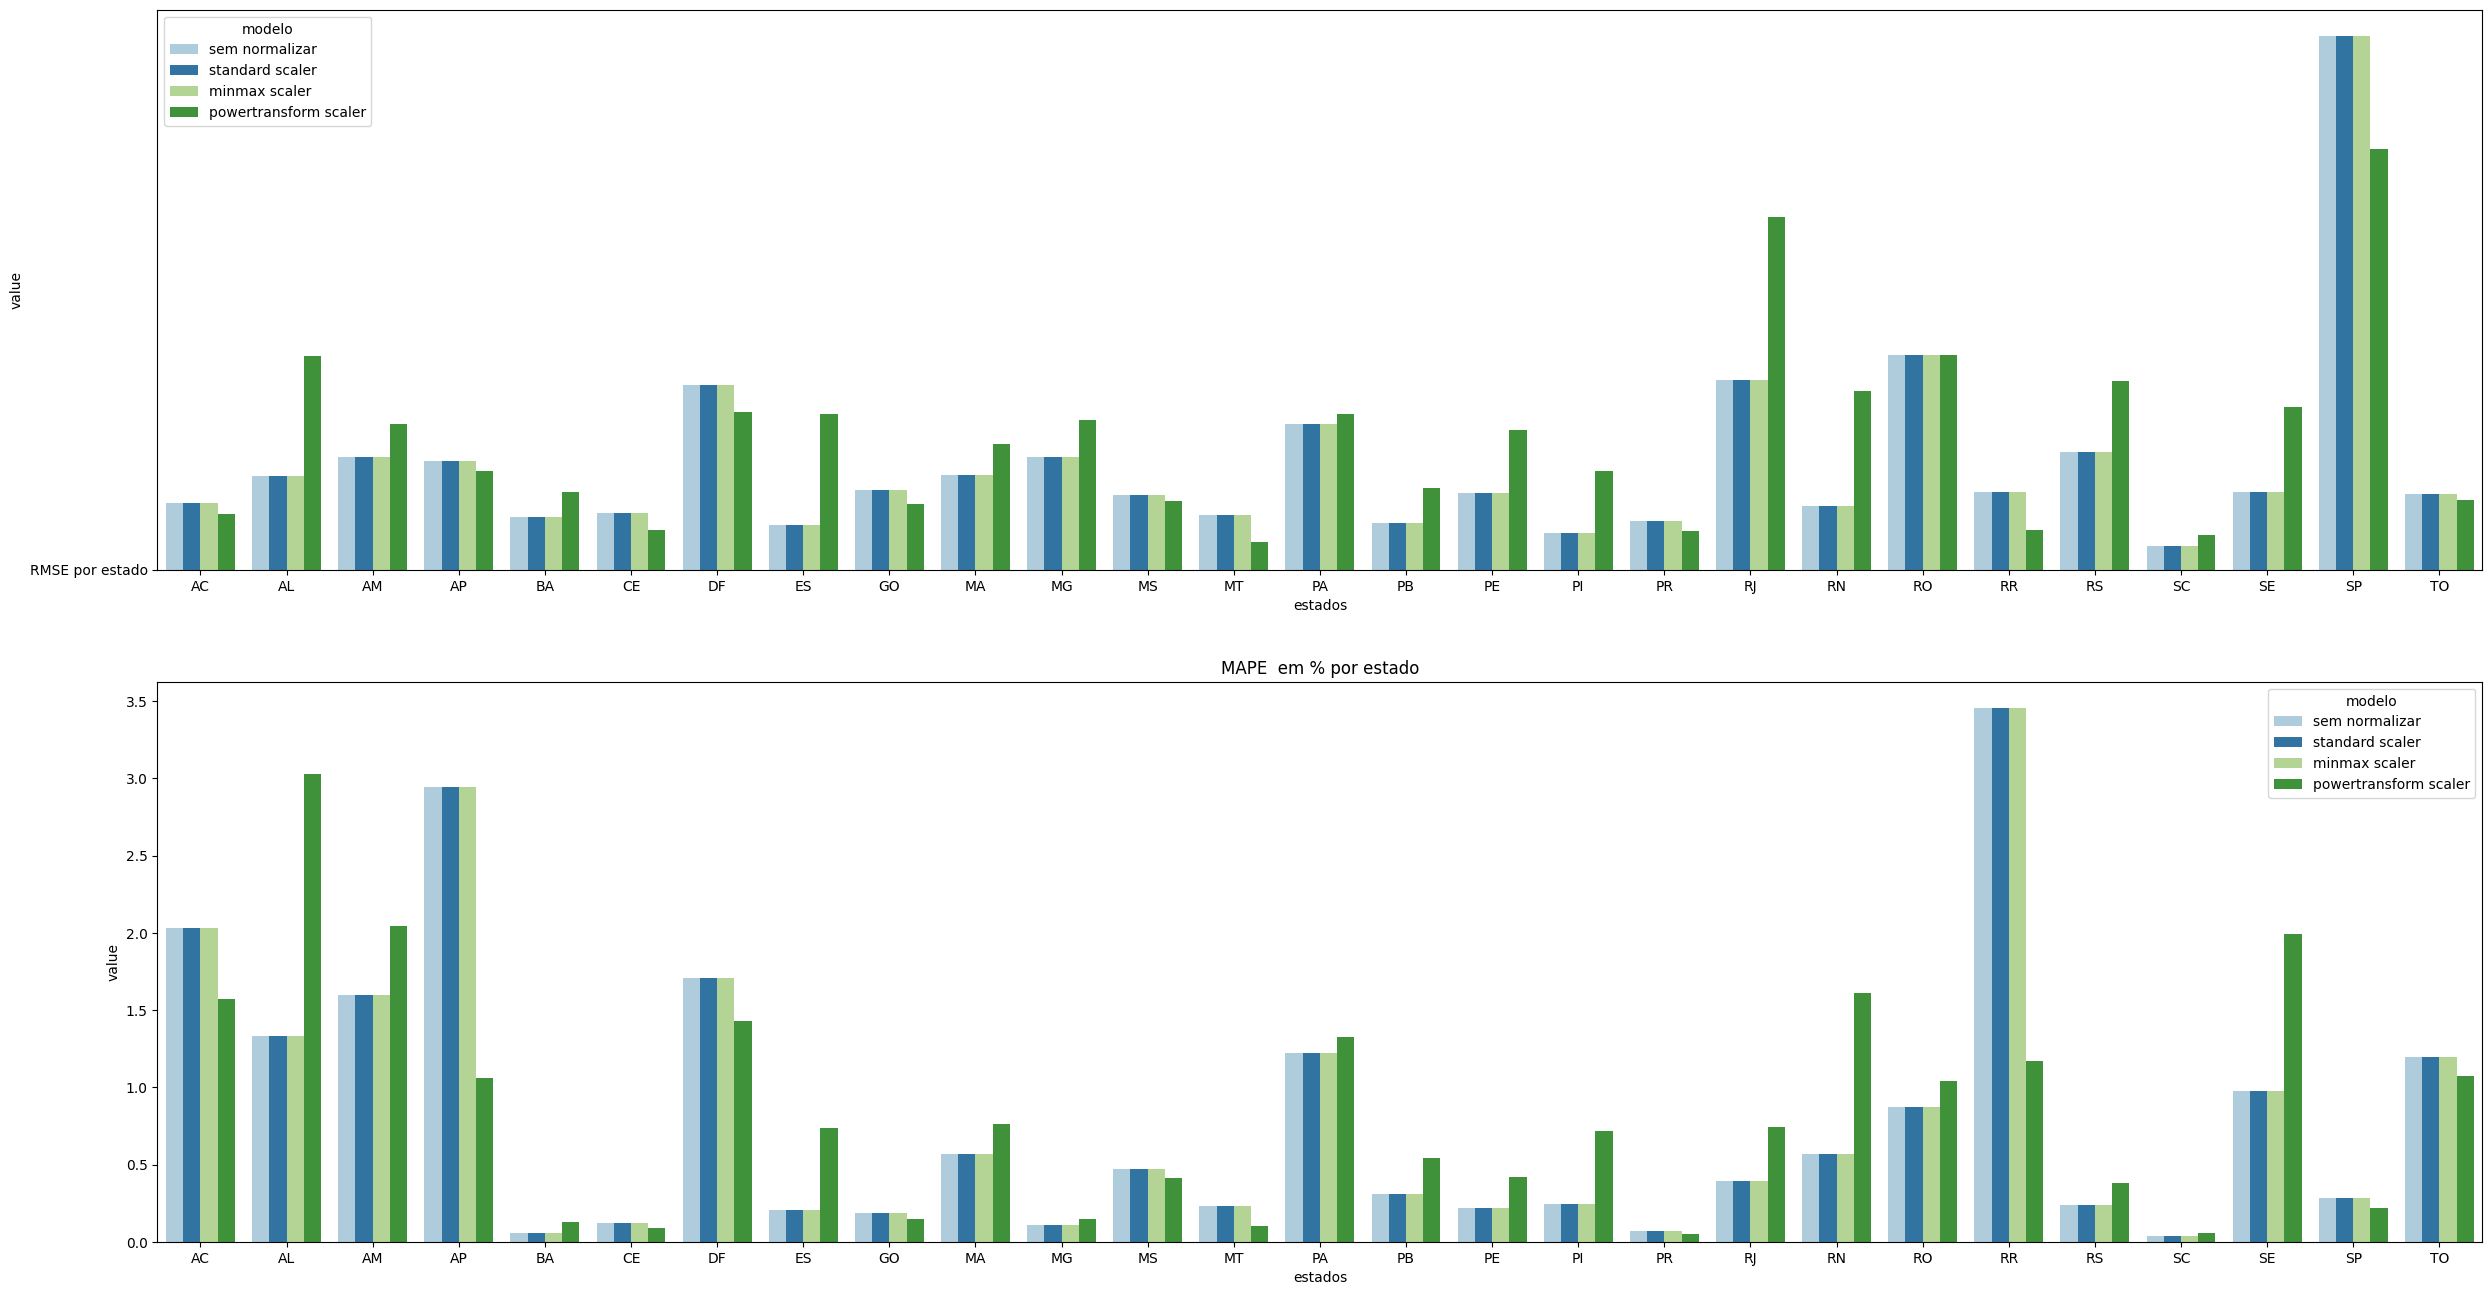

In [33]:
df = pd.melt(df_error, id_vars=["estados", "indicador"],value_vars=["sem normalizar", "standard scaler", "minmax scaler", "powertransform scaler"], var_name='modelo')

plt.figure(figsize=(30,16))

plt.subplot(2,1,1)

plt.plot("RMSE por estado")
sns.barplot(data=df[df["indicador"] == "RMSE"], x="estados", y="value", hue="modelo", palette="Paired")

plt.subplot(2,1,2)

sns.barplot(data=df[df["indicador"] == "MAPE"], x="estados", y="value", hue="modelo", palette="Paired")
plt.title("MAPE  em % por estado")

plt.show()

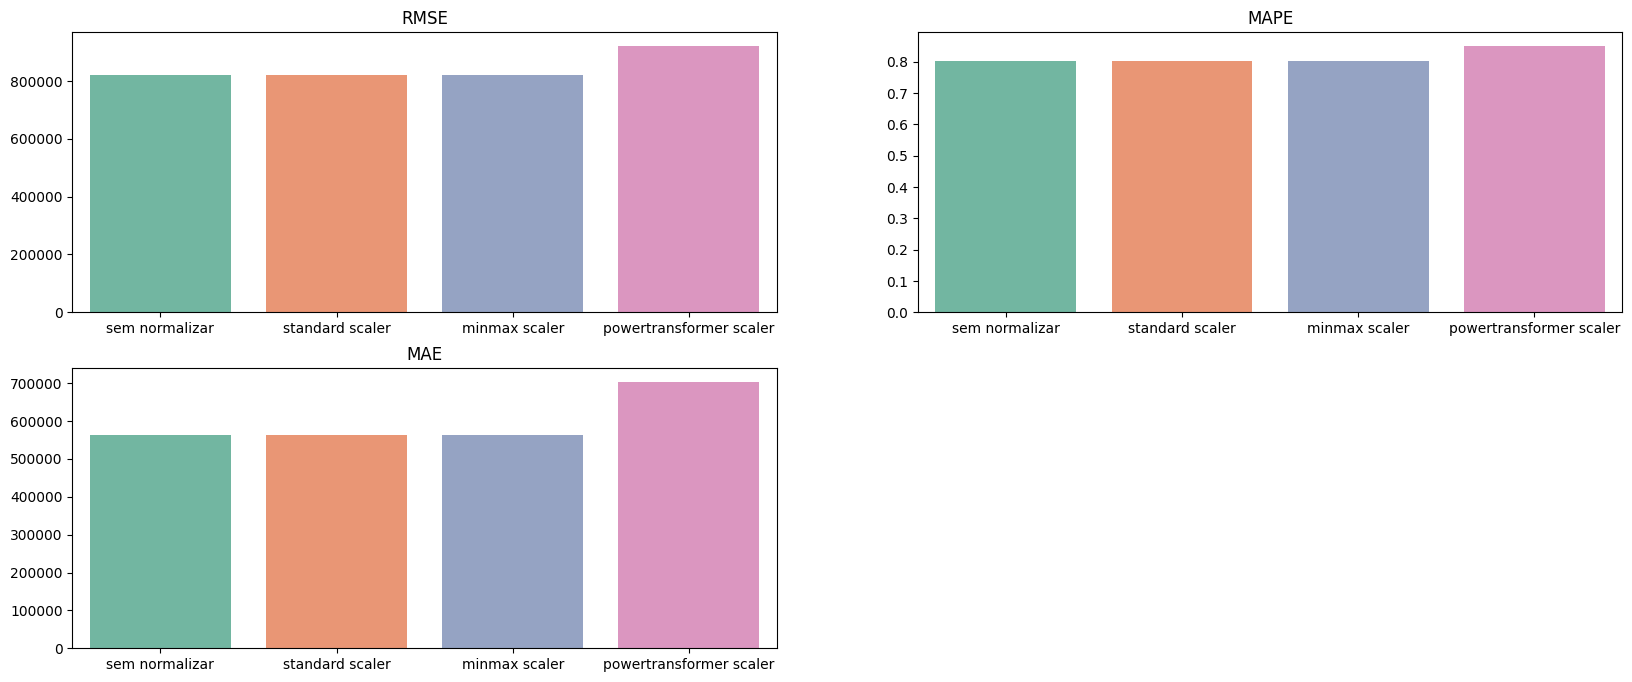

In [34]:
plt.figure(figsize=(20,8))

plt.subplot(2,2,1)

plt.title("RMSE")
sns.barplot(df_geral[df_geral["indicador"]=="RMSE"])

plt.subplot(2,2,2)

plt.title("MAPE")
sns.barplot(df_geral[df_geral["indicador"]=="MAPE"])

plt.subplot(2,2,3)

plt.title("MAE")
sns.barplot(df_geral[df_geral["indicador"]=="MAE"])

plt.show()

# Modelo para cada estado

In [35]:
df_error = pd.DataFrame(SIGLAS*2, columns=["estados"])
df_error.sort_values("estados", inplace=True)
df_error["indicador"] = ["RMSE","MAPE"]*27

df_geral = pd.DataFrame(["RMSE", "MAPE", "MAE"], columns=["indicador"])

## Sem normalizar os dados

In [36]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")[["estados", 'consumo']]

In [37]:
pred = {}

y_test_states = {}

values = []

for i in range(27):

    x_state = x[x["estados"] == SIGLAS[i]]
    y_state = y[y["estados"] == SIGLAS[i]]["consumo"]

    x_state = x_state.drop("estados", axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x_state, y_state, test_size=0.15, shuffle=False)

    y_test_states[i] = y_test.reset_index(drop=True)

    regr = LinearRegression()

    regr.fit(x_train, y_train)

    print(f"[{SIGLAS[i]}]: Score: {regr.score(x_test, y_test)}")

    pred[SIGLAS[i]] = {"y_pred": regr.predict(x_test), "y_test": np.array(y_test)}
    
    values += [ mean_squared_error(pred[SIGLAS[i]]["y_test"],pred[SIGLAS[i]]["y_pred"]), mean_absolute_percentage_error(pred[SIGLAS[i]]["y_test"],pred[SIGLAS[i]]["y_pred"])]
    
df_error["sem normalizar"]= values
    

[AC]: Score: -0.7509924201715146
[AL]: Score: -14.056420426985
[AM]: Score: -1.382839015369318
[AP]: Score: -0.29080576825722715
[BA]: Score: 0.36923755431590743
[CE]: Score: -5.105413569961478
[DF]: Score: -16.722909703530938
[ES]: Score: -9.721460947499777
[GO]: Score: -9.974795643288221
[MA]: Score: 0.6690763829482378
[MG]: Score: -2.00182416676053
[MS]: Score: -11.409307424609054
[MT]: Score: -4.669674143887656
[PA]: Score: -4.791578354629314
[PB]: Score: -1.071984820603992
[PE]: Score: -10.415906433444013
[PI]: Score: -11.710133606700055
[PR]: Score: -64.9493126385286
[RJ]: Score: -0.2836127308664955
[RN]: Score: -6.987354794537881
[RO]: Score: -0.5043290409457315
[RR]: Score: -0.6622651082401312
[RS]: Score: -40.95229069636414
[SC]: Score: -15.31397781549892
[SE]: Score: -1.7766659484357494
[SP]: Score: -38.09499114961491
[TO]: Score: -0.6921884379789738


In [38]:
p = np.array([i["y_pred"] for i in list(pred.values())]).flatten()
r = np.array([i["y_test"] for i in list(pred.values())]).flatten()

scores = score_regression_metrics(r, p)
show_scores(scores)

df_geral["sem normalizar"] = [scores["neg_root_mean_squared_error"], scores["neg_mean_absolute_percentage_error"], scores["neg_mean_absolute_error"]]

Scores obtidos:
RMSE: 1631403.2708758507
MAE: 760545.1921523216
MAPE: 0.46331178961961844


## Normalizando os dados

### Normalização com Standard Scaler

In [39]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")[["estados", 'consumo']]

In [40]:
pred = {}

y_test_states = {}

values = []

for i in range(27):

    x_state = x[x["estados"] == SIGLAS[i]]
    y_state = y[y["estados"] == SIGLAS[i]]["consumo"]

    x_state = x_state.drop("estados", axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x_state, y_state, test_size=0.15, shuffle=False)

    # normalizacao
    
    # calcula media e desvio padrao do treino e normaliza os dados
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    y_test_states[i] = y_test.reset_index(drop=True)

    regr = LinearRegression()

    regr.fit(x_train, y_train)

    print(f"[{SIGLAS[i]}]: Score: {regr.score(x_test, y_test)}")

    pred[SIGLAS[i]] = {"y_pred": regr.predict(x_test), "y_test": y_test}
    
    values += [ mean_squared_error(pred[SIGLAS[i]]["y_test"],pred[SIGLAS[i]]["y_pred"]), mean_absolute_percentage_error(pred[SIGLAS[i]]["y_test"],pred[SIGLAS[i]]["y_pred"])]

df_error["standard scaler"]=values

[AC]: Score: -0.7509925332506922
[AL]: Score: -14.056420215058937
[AM]: Score: -1.3828389653518163
[AP]: Score: -0.29080576885079945
[BA]: Score: 0.36923758556800257
[CE]: Score: -5.105414715080028
[DF]: Score: -16.722909879464986
[ES]: Score: -9.72146103045463
[GO]: Score: -9.974795658316772
[MA]: Score: 0.6690764163525813
[MG]: Score: -2.0018241720812906
[MS]: Score: -11.409307467112086
[MT]: Score: -4.6696741541234275
[PA]: Score: -4.791578127023652
[PB]: Score: -1.0719848243625685
[PE]: Score: -10.41590672797209
[PI]: Score: -11.710130758837744
[PR]: Score: -64.9493134392047
[RJ]: Score: -0.2836127589164632
[RN]: Score: -6.987354769198913
[RO]: Score: -0.5043290398342901
[RR]: Score: -0.6622651141020879
[RS]: Score: -40.95229057311697
[SC]: Score: -15.313977817968944
[SE]: Score: -1.7766657334494855
[SP]: Score: -38.0949934199516
[TO]: Score: -0.6921884344658165


In [41]:
p = np.array([i["y_pred"] for i in list(pred.values())]).flatten()
r = np.array([i["y_test"] for i in list(pred.values())]).flatten()

scores = score_regression_metrics(r, p)
show_scores(scores)

df_geral["standard scaler"] = [scores["neg_root_mean_squared_error"], scores["neg_mean_absolute_percentage_error"], scores["neg_mean_absolute_error"]]

Scores obtidos:
RMSE: 1631403.3087928714
MAE: 760545.2008694756
MAPE: 0.46331178773335824


### Normalização com MinMax

In [42]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")[["estados", 'consumo']]

In [43]:
pred = {}

y_test_states = {}

values = []

for i in range(27):

    x_state = x[x["estados"] == SIGLAS[i]]
    y_state = y[y["estados"] == SIGLAS[i]]["consumo"]

    x_state = x_state.drop("estados", axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x_state, y_state, test_size=0.15, shuffle=False)

    # normalizacao
    
    # calcula media e desvio padrao do treino e normaliza os dados
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    y_test_states[i] = y_test.reset_index(drop=True)

    regr = LinearRegression()

    regr.fit(x_train, y_train)

    print(f"[{SIGLAS[i]}]: Score: {regr.score(x_test, y_test)}")

    pred[SIGLAS[i]] = {"y_pred": regr.predict(x_test), "y_test": y_test}
    
    values += [ mean_squared_error(pred[SIGLAS[i]]["y_test"],pred[SIGLAS[i]]["y_pred"]), mean_absolute_percentage_error(pred[SIGLAS[i]]["y_test"],pred[SIGLAS[i]]["y_pred"])]

    
df_error["minmax scaler"]=values

[AC]: Score: -0.750992533250697
[AL]: Score: -14.056420215060534
[AM]: Score: -1.38283896535177
[AP]: Score: -0.2908057688507988
[BA]: Score: 0.369237585568003
[CE]: Score: -5.105414715079814
[DF]: Score: -16.72290987946502
[ES]: Score: -9.721461030454684
[GO]: Score: -9.974795658316822
[MA]: Score: 0.6690764163525883
[MG]: Score: -2.0018241720813847
[MS]: Score: -11.409307467112226
[MT]: Score: -4.6696741541233395
[PA]: Score: -4.791578127023639
[PB]: Score: -1.0719848243626897
[PE]: Score: -10.415906727972205
[PI]: Score: -11.710130758837632
[PR]: Score: -64.94931343920722
[RJ]: Score: -0.2836127589164752
[RN]: Score: -6.987354769198931
[RO]: Score: -0.504329039834295
[RR]: Score: -0.6622651141020874
[RS]: Score: -40.95229057311628
[SC]: Score: -15.313977817969047
[SE]: Score: -1.7766657334494838
[SP]: Score: -38.094993419949255
[TO]: Score: -0.6921884344658242


In [44]:
p = np.array([i["y_pred"] for i in list(pred.values())]).flatten()
r = np.array([i["y_test"] for i in list(pred.values())]).flatten()

scores = score_regression_metrics(r, p)
show_scores(scores)

df_geral["minmax scaler"] = [scores["neg_root_mean_squared_error"], scores["neg_mean_absolute_percentage_error"], scores["neg_mean_absolute_error"]]

Scores obtidos:
RMSE: 1631403.3087928349
MAE: 760545.2008694716
MAPE: 0.4633117877333599


### Normalização com PowerTransform

In [45]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")[["estados", 'consumo']]

In [46]:
pred = {}

y_test_states = {}

values = []

for i in range(27):

    x_state = x[x["estados"] == SIGLAS[i]]
    y_state = y[y["estados"] == SIGLAS[i]]["consumo"]

    x_state = x_state.drop("estados", axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x_state, y_state, test_size=0.15, shuffle=False)

    # normalizacao
    
    # calcula media e desvio padrao do treino e normaliza os dados
    scaler = PowerTransformer()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    y_test_states[i] = y_test.reset_index(drop=True)

    regr = LinearRegression()

    regr.fit(x_train, y_train)

    print(f"[{SIGLAS[i]}]: Score: {regr.score(x_test, y_test)}")

    pred[SIGLAS[i]] = {"y_pred": regr.predict(x_test), "y_test": y_test}
    
    values += [ mean_squared_error(pred[SIGLAS[i]]["y_test"],pred[SIGLAS[i]]["y_pred"]), mean_absolute_percentage_error(pred[SIGLAS[i]]["y_test"],pred[SIGLAS[i]]["y_pred"])]
    
df_error["powertransformer scaler"]=values

[AC]: Score: -0.14508347310248548
[AL]: Score: 0.6393078364827796
[AM]: Score: -0.2804019020653292
[AP]: Score: -0.26721261634429494
[BA]: Score: 0.3829197547841514
[CE]: Score: -1.8563121028684222
[DF]: Score: -5.257693068890225
[ES]: Score: -2.675576659804959
[GO]: Score: -2.930905474869551
[MA]: Score: -4.328593531117424
[MG]: Score: 0.2548222600440311
[MS]: Score: 0.2351502475471231
[MT]: Score: -5.060655102204143
[PA]: Score: -5.755276848428421
[PB]: Score: -2.3861606780179616
[PE]: Score: -1.7547652183613147
[PI]: Score: -12.817771615339266
[PR]: Score: -13.00441595726418
[RJ]: Score: -8.728997886640467
[RN]: Score: -1.9423117946306938
[RO]: Score: -0.7869589489901676
[RR]: Score: -0.3977689336016277
[RS]: Score: -20.15359817634814
[SC]: Score: -0.0843687023206856
[SE]: Score: -2.197099402123269
[SP]: Score: -9.7894258273341
[TO]: Score: -0.08559489958605115


In [47]:
p = np.array([i["y_pred"] for i in list(pred.values())]).flatten()
r = np.array([i["y_test"] for i in list(pred.values())]).flatten()

scores = score_regression_metrics(r, p)
show_scores(scores)

df_geral["powertransformer scaler"] = [scores["neg_root_mean_squared_error"], scores["neg_mean_absolute_percentage_error"], scores["neg_mean_absolute_error"]]

Scores obtidos:
RMSE: 1039996.6693423768
MAE: 557714.9465972045
MAPE: 0.3986806666650387


## Comparação de Desempenho

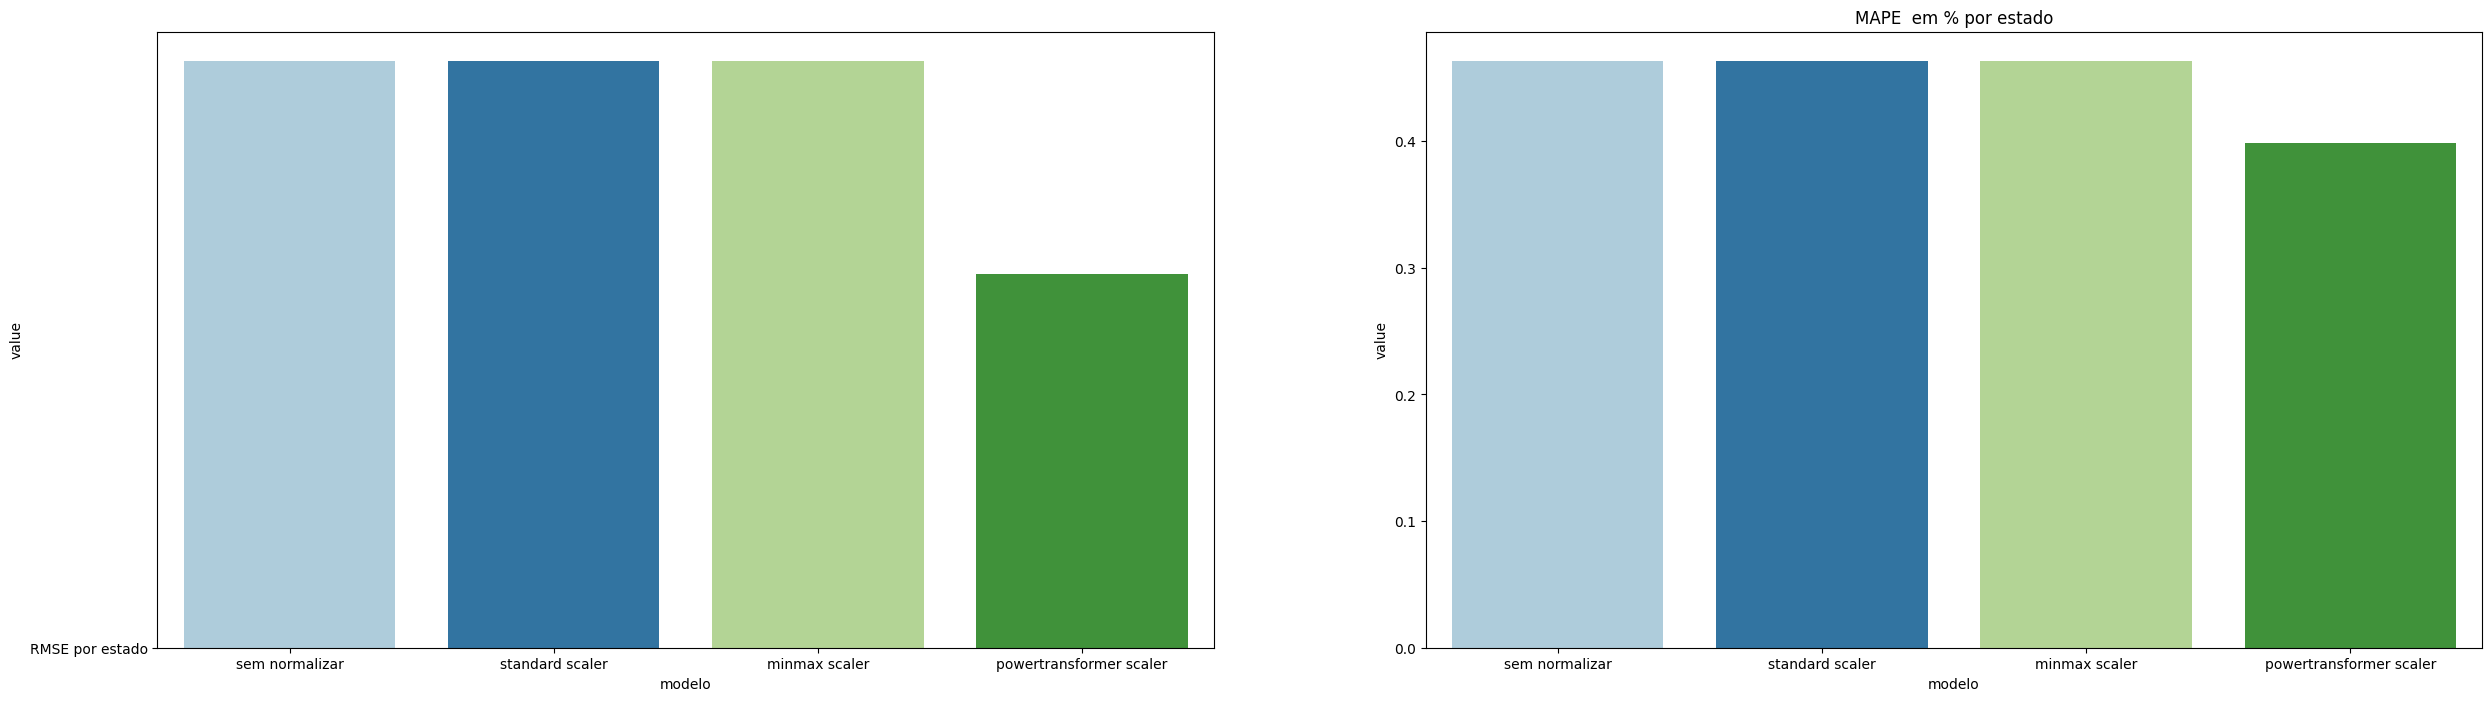

In [48]:
df_geral = pd.melt(df_geral, id_vars=["indicador"],value_vars=["sem normalizar", "standard scaler", "minmax scaler", "powertransformer scaler"], var_name='modelo')

plt.figure(figsize=(30,8))

plt.subplot(1,2,1)

plt.yscale('linear')
plt.plot("RMSE por estado")
sns.barplot(data=df_geral[df_geral["indicador"] == "RMSE"], x="modelo", y="value", palette="Paired")

plt.subplot(1,2,2)

sns.barplot(data=df_geral[df_geral["indicador"] == "MAPE"], x="modelo", y="value", palette="Paired")
plt.title("MAPE  em % por estado")

plt.show()

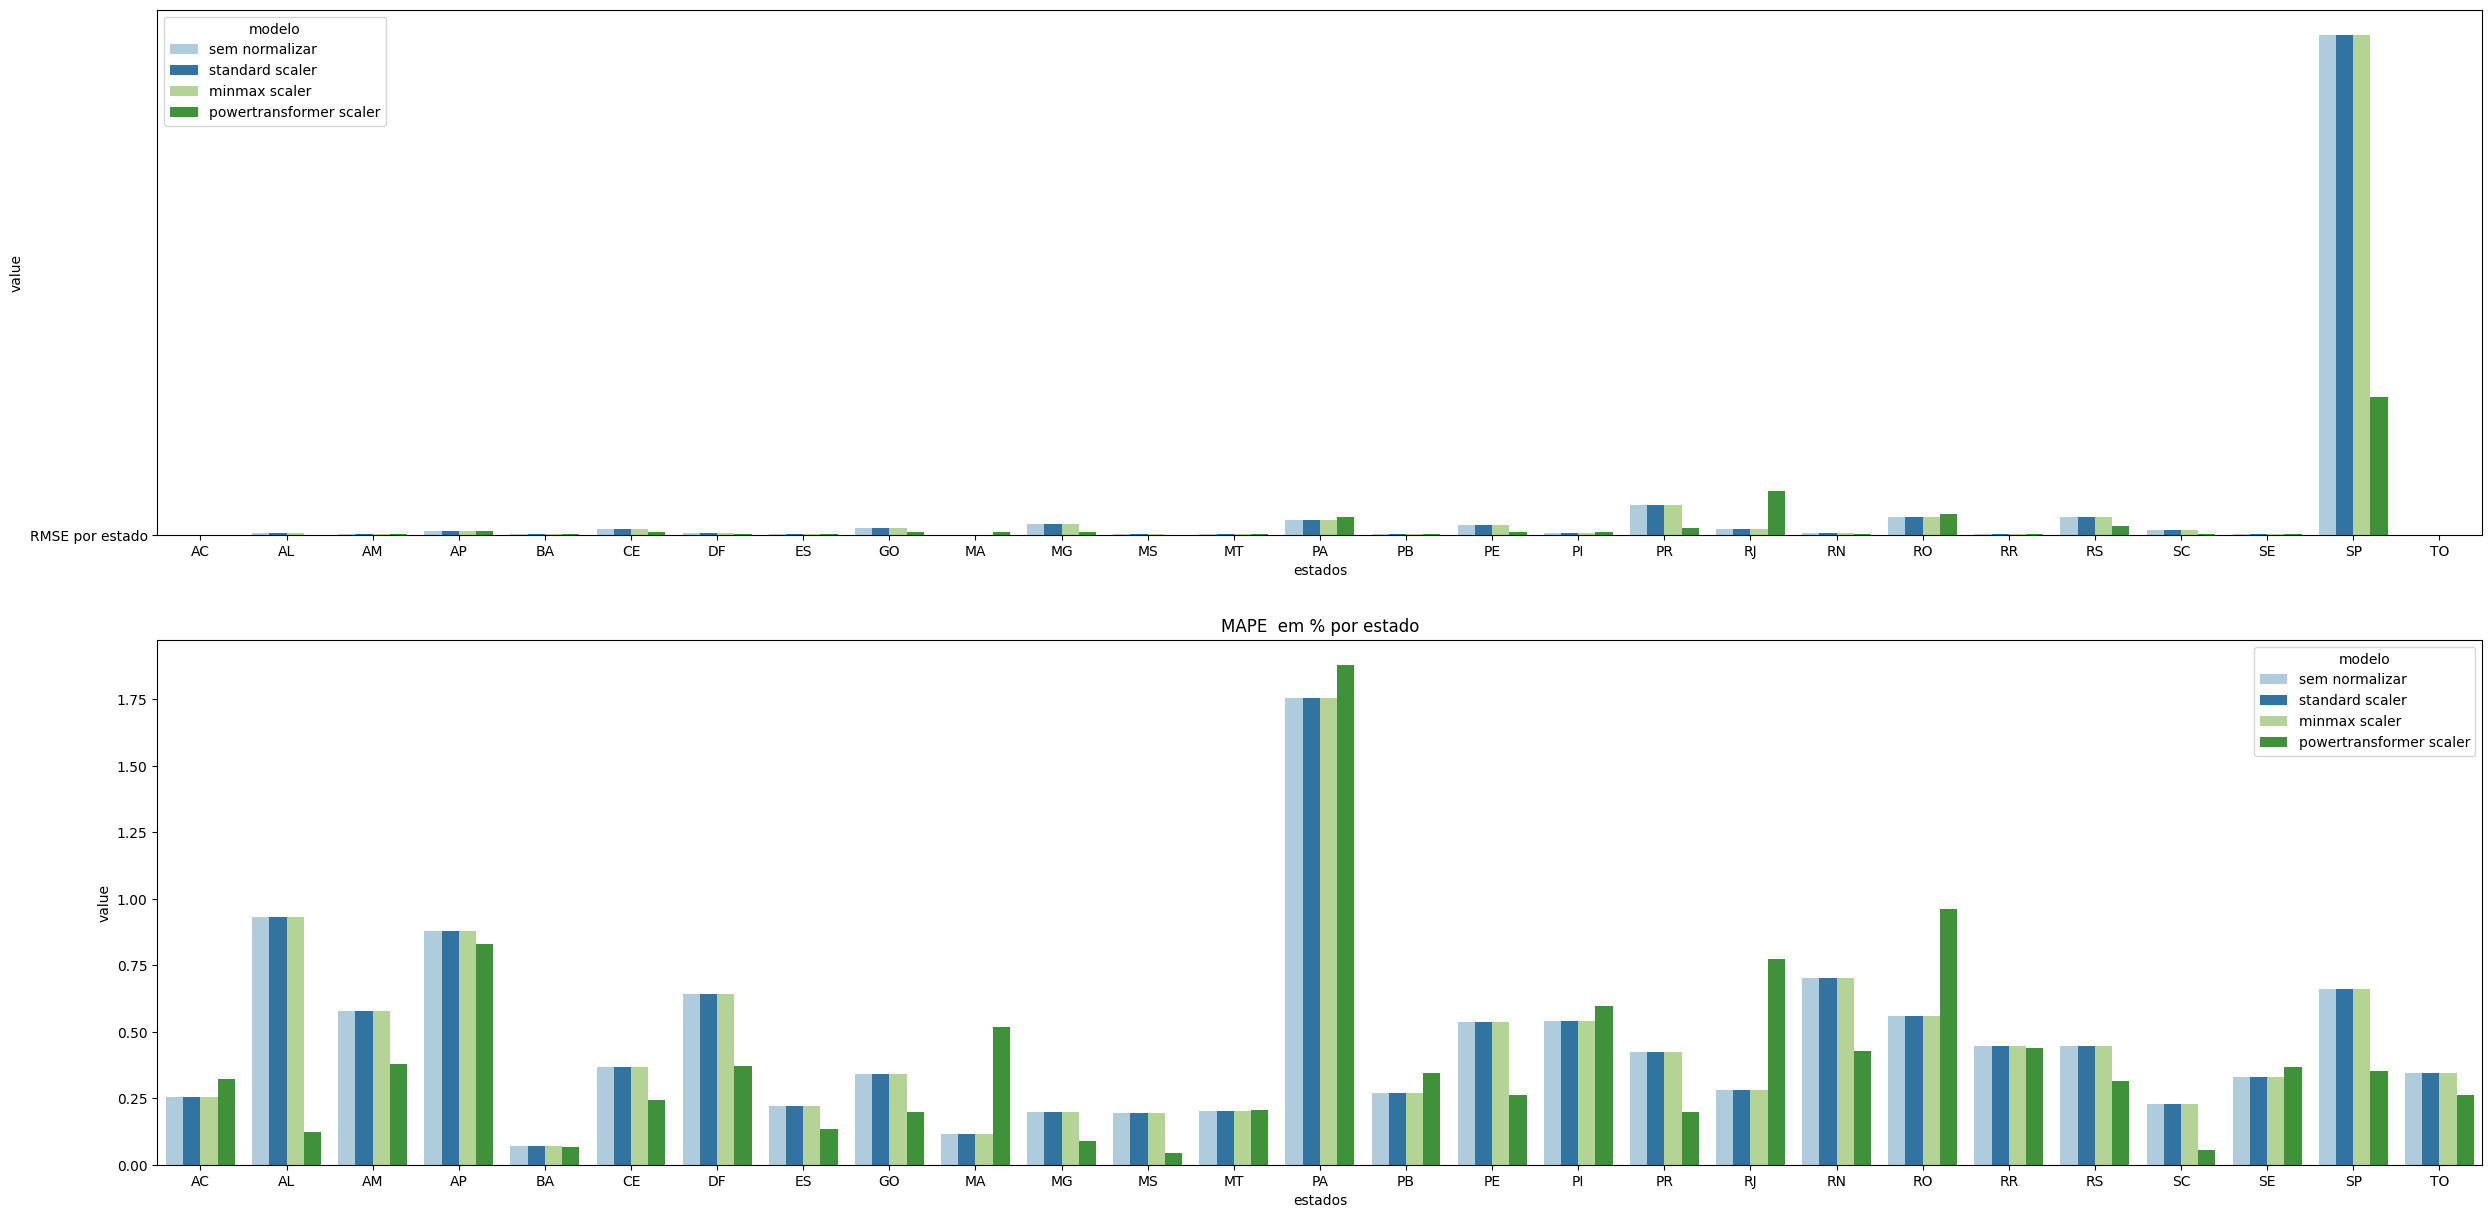

In [49]:
df = pd.melt(df_error, id_vars=["estados", "indicador"],value_vars=["sem normalizar", "standard scaler", "minmax scaler", "powertransformer scaler"], var_name='modelo')

plt.figure(figsize=(30,15))

plt.subplot(2,1,1)

plt.yscale('linear')
plt.plot("RMSE por estado")
sns.barplot(data=df[df["indicador"] == "RMSE"], x="estados", y="value", hue="modelo", palette="Paired")

plt.subplot(2,1,2)

sns.barplot(data=df[df["indicador"] == "MAPE"], x="estados", y="value", hue="modelo", palette="Paired")
plt.title("MAPE  em % por estado")

plt.show()

# Resultados:

Métricas de **Erro** de acordo com o melhor modelo de cada tipo (por estado) e único para todos os estados:

|      | Modelo Por Estado | Modelo Único |
|------|-------------------|--------------|
| RMSE | 1039996           | 821444       |
| MAPE | 39%               | 80%          |
| MAE  | 557714            | 562083       |

In [50]:
df_error = pd.DataFrame(SIGLAS*2, columns=["estados"])
df_error["indicador"] = ["RMSE"]*27 + ["MAPE"]*27

## Modelo único

In [51]:
# input
x = pd.read_csv("https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/input.csv")

# processo de one-hot
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)
x.drop("data", inplace=True, axis=1)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv("https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/target_ac.csv")['consumo']

# shuffle = False para os dados continuarem em ordem 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

# fazendo previsão 
y_pred = regr.predict(x_test)

Score: 0.8633707869138146


In [52]:
y_pred = y_pred[6:]
y_test = y_test[6:]

In [53]:
y_pred_state = split_y_state(y_pred)
y_test_state = split_y_state(y_test)

df_error["modelo único"] = print_error(y_pred_state,y_test_state)

In [54]:
pred_u = {}

for i in range(27):
    pred_u[SIGLAS[i]] = {"y_test":y_test_state[i],
                       "y_pred":y_pred_state[i]}

In [55]:
df_error = df_error.sort_values(["estados", "indicador"]).reset_index(drop=True)

## Modelo por estado com Powertransformer

In [56]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")[["estados", 'consumo']]

pred_e = {}

y_test_states = {}

values = []

for i in range(27):

    x_state = x[x["estados"] == SIGLAS[i]]
    y_state = y[y["estados"] == SIGLAS[i]]["consumo"]

    x_state = x_state.drop("estados", axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x_state, y_state, test_size=0.15, shuffle=False)

    # normalizacao
    
    # calcula media e desvio padrao do treino e normaliza os dados
    scaler = PowerTransformer()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    y_test_states[i] = y_test.reset_index(drop=True)

    regr = LinearRegression()

    regr.fit(x_train, y_train)

    pred_e[SIGLAS[i]] = {"y_pred": regr.predict(x_test), "y_test": np.array(y_test)}
    
    values += [mean_absolute_percentage_error(pred[SIGLAS[i]]["y_test"],pred[SIGLAS[i]]["y_pred"]), mean_squared_error(pred[SIGLAS[i]]["y_test"],pred[SIGLAS[i]]["y_pred"], squared=False)]
    
df_error["modelo por estado"]=values

## Comparação

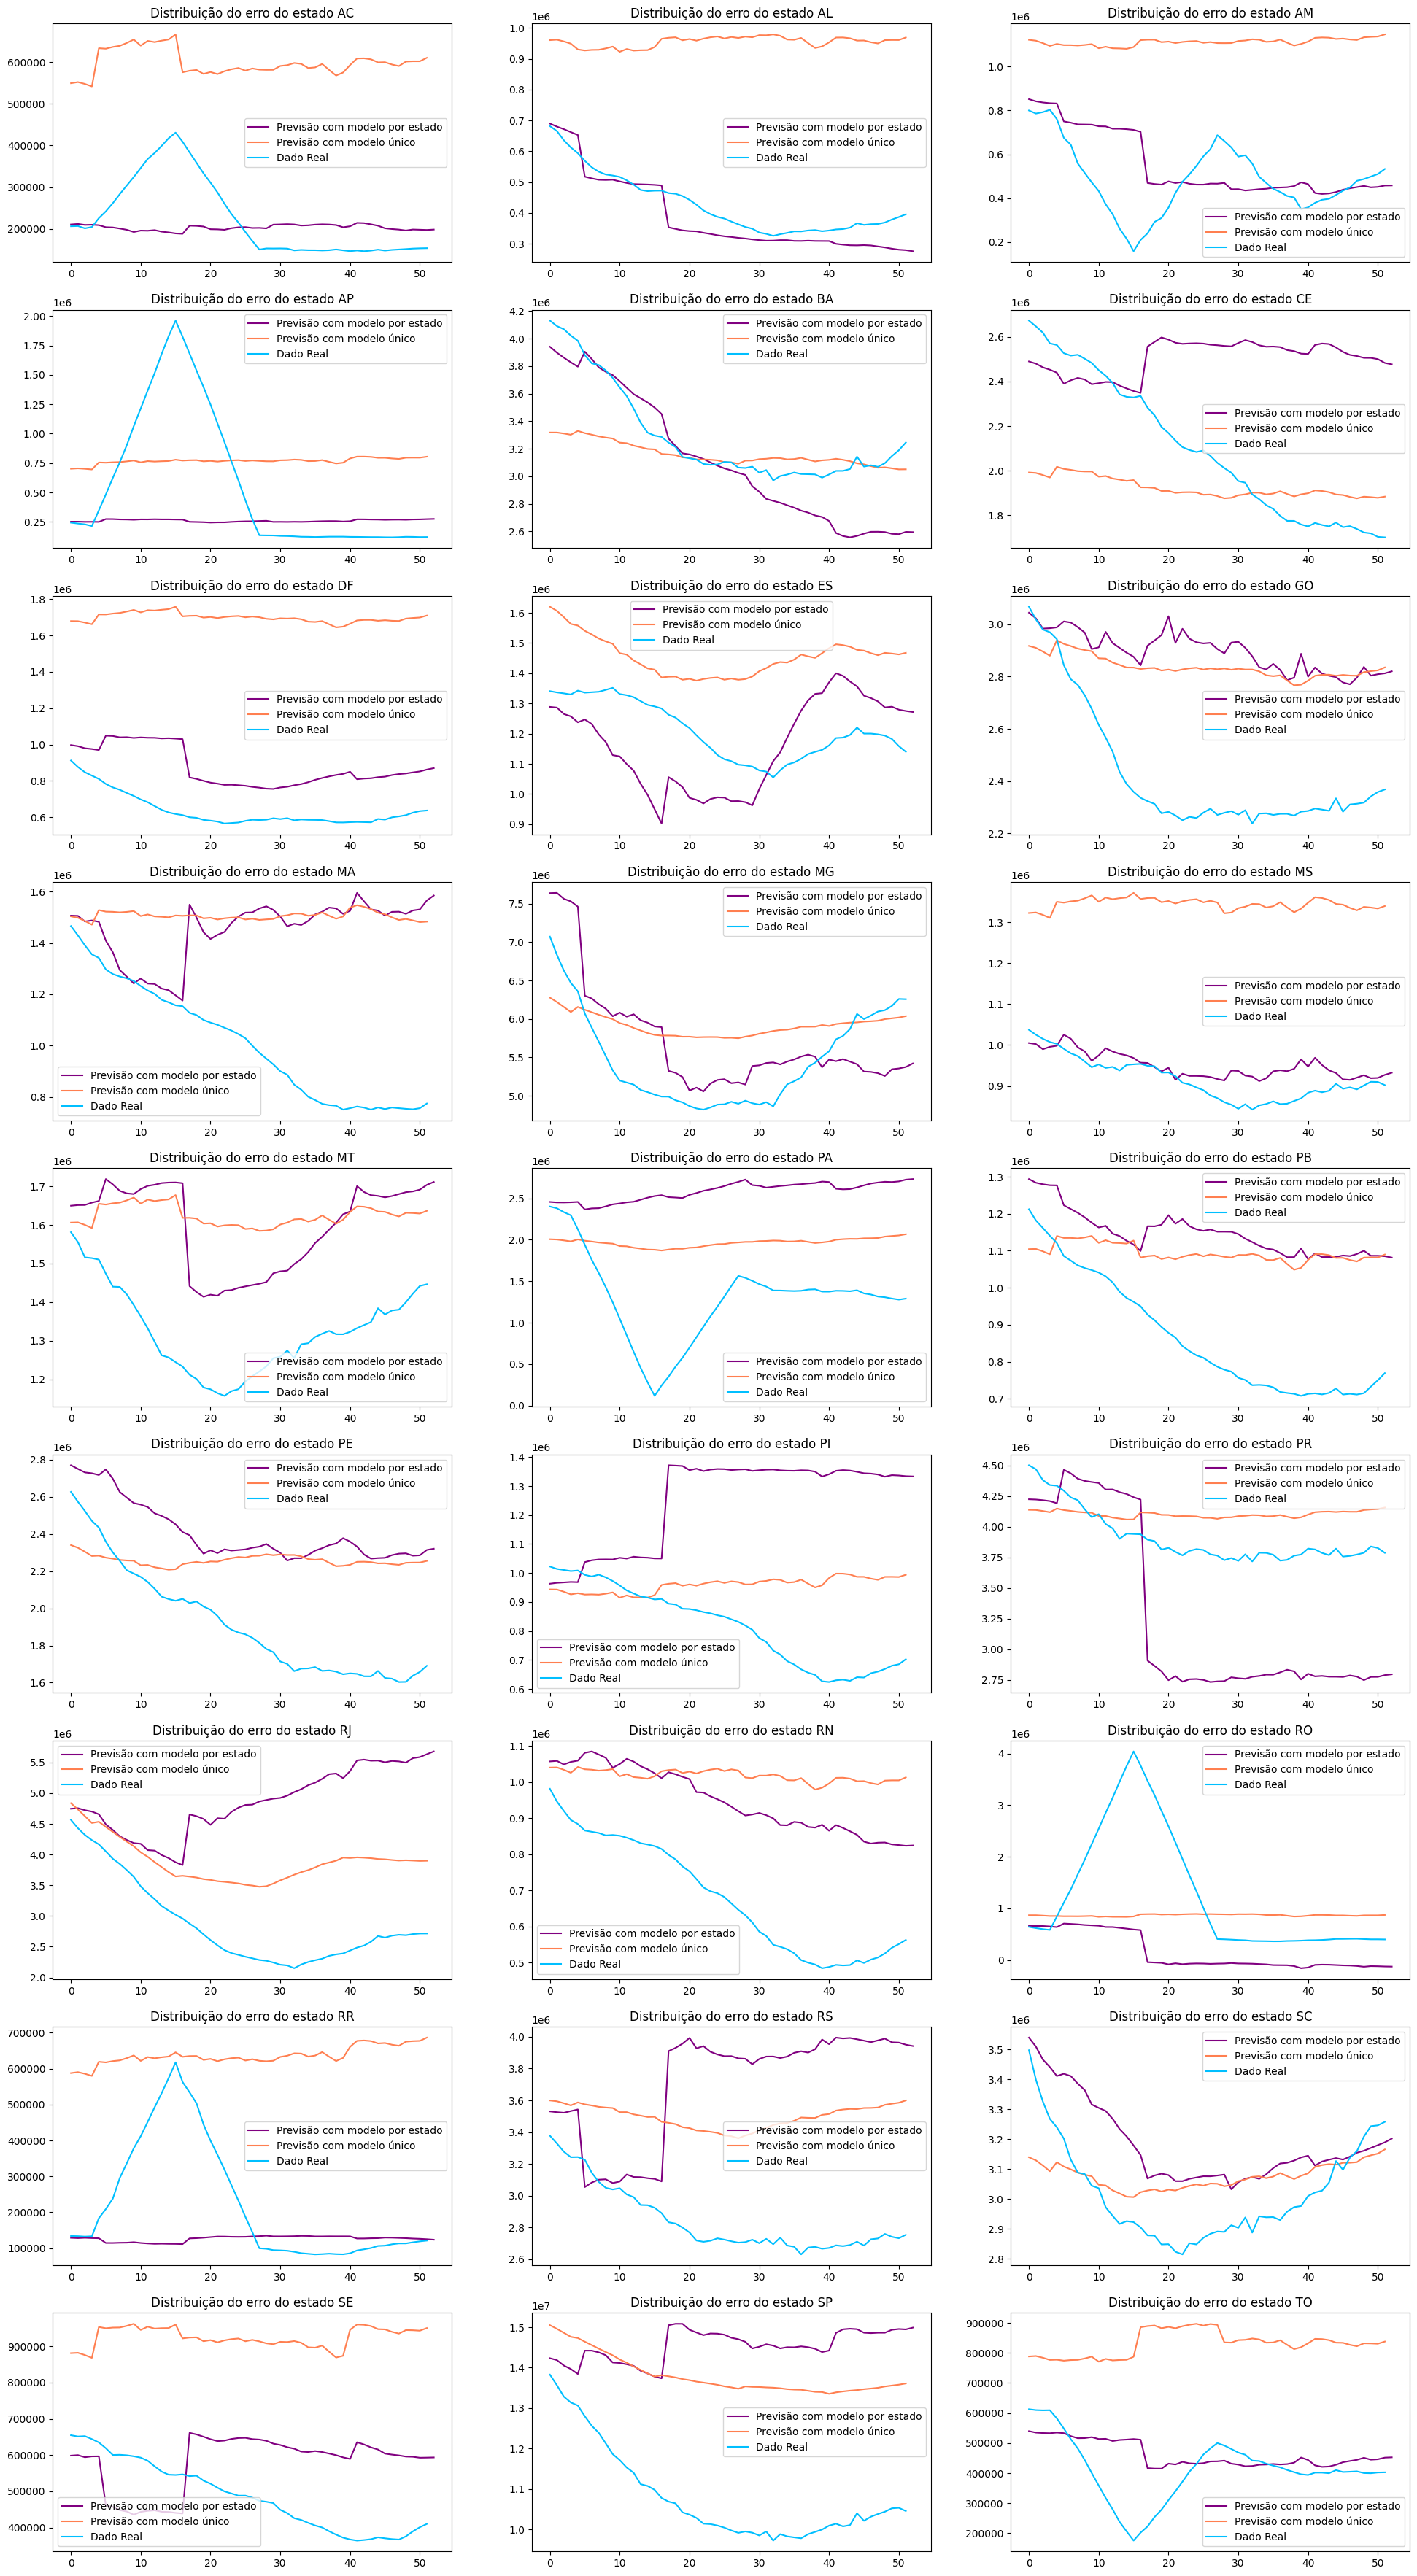

In [57]:
compare_pred(pred_u, "modelo único", pred_e, "modelo por estado")

In [58]:
df = pd.melt(df_error, id_vars=["estados", "indicador"],value_vars=["modelo único", "modelo por estado"], var_name='modelo')

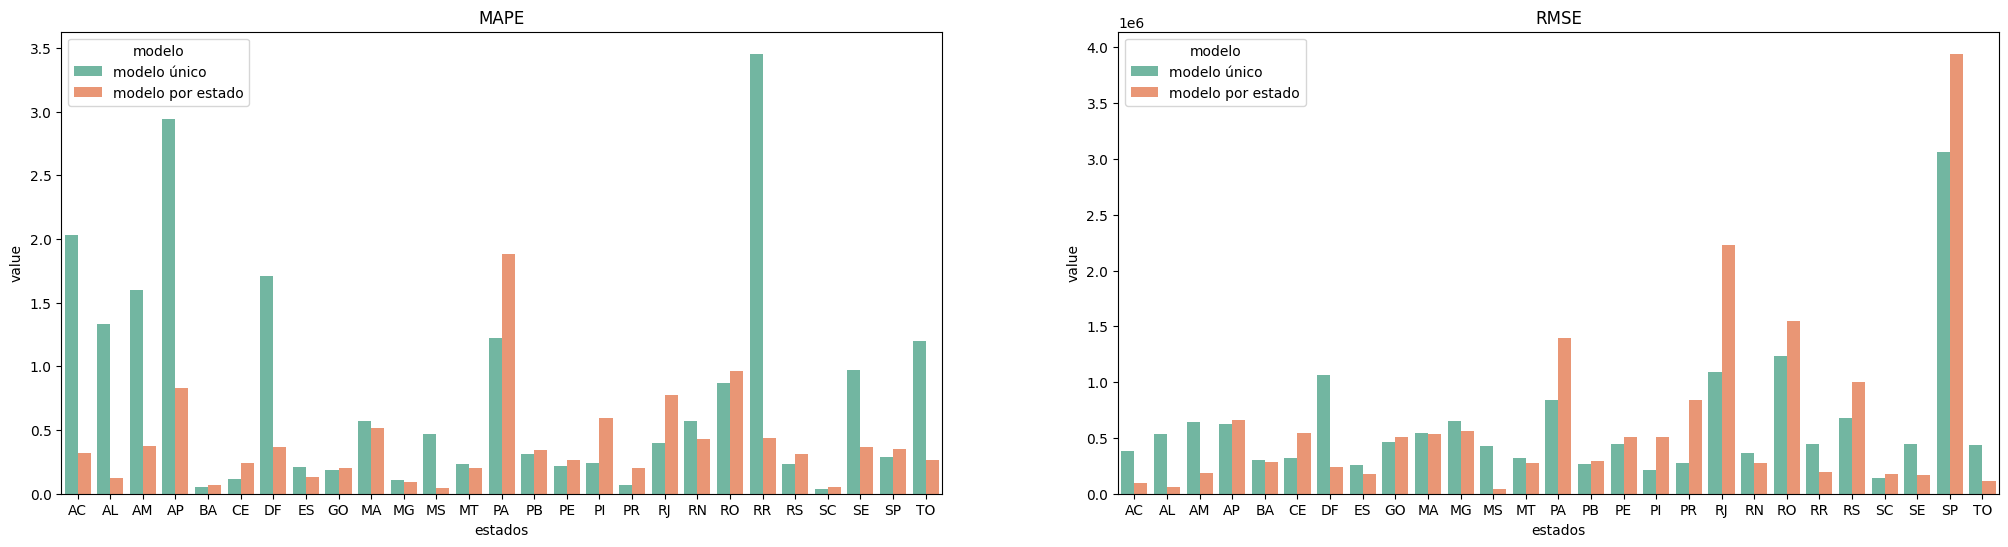

In [59]:
plt.figure(figsize=(25,6))

plt.subplot(1,2,1)

plt.title("MAPE")
sns.barplot(data=df[df["indicador"] == "MAPE"], x="estados", y="value", hue="modelo")

plt.subplot(1,2,2)

plt.title("RMSE")
plt.yscale("linear")
sns.barplot(data=df[df["indicador"] == "RMSE"], x="estados", y="value", hue="modelo")

plt.show()

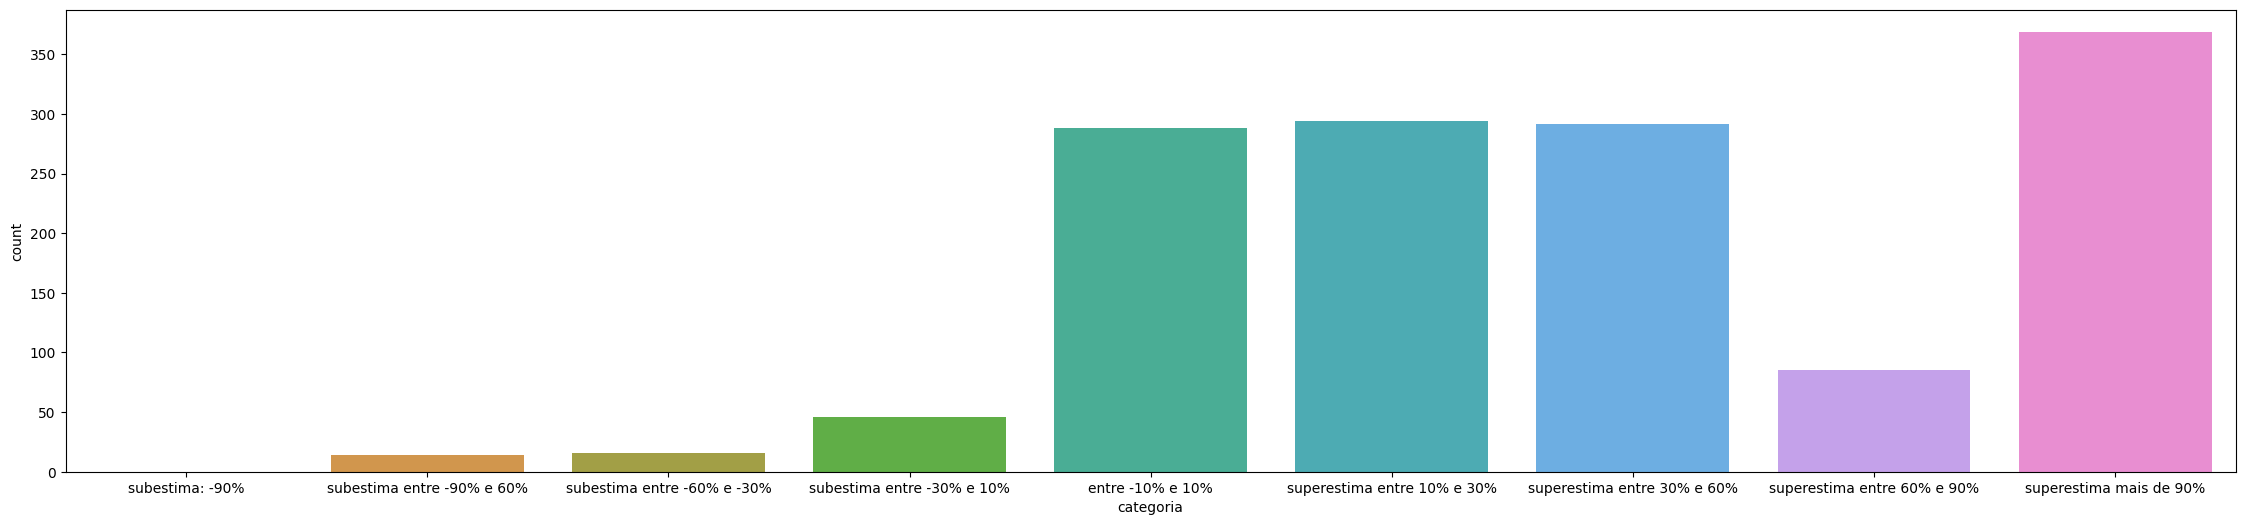

In [60]:
# Modelo único
show_delta(pred_u)

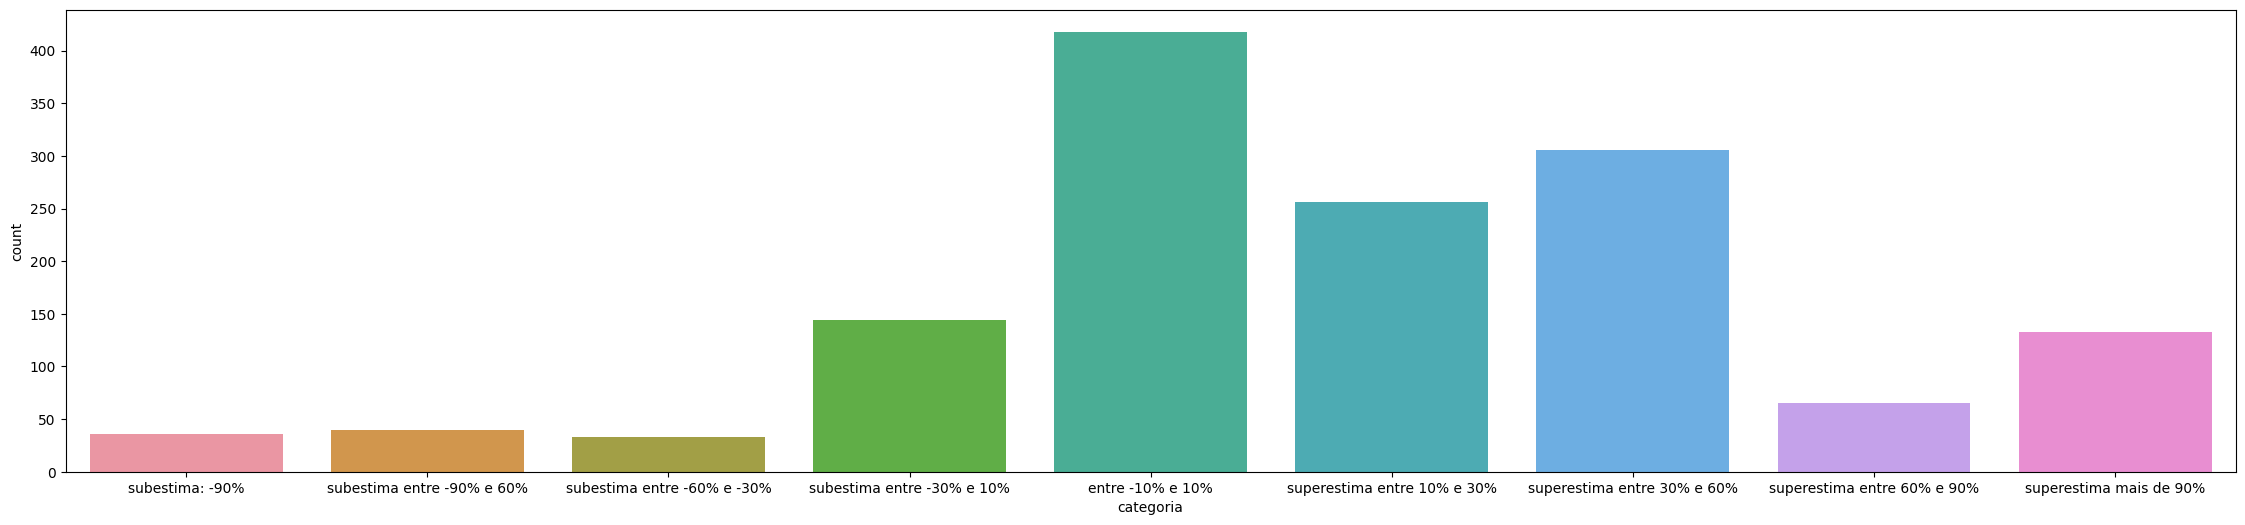

In [61]:
# modelo por estado
show_delta(pred_e)